# Orfeo ToolBox internals

## Description

### Summary 

This exercise introduces Orfeo the ToolBox pipeline internals.

* Extended filenames,
* Streaming,
* Multi-threading,
* Environment variables,
* geom files.

### Prerequisites

* Installed Monteverdi and Orfeo ToolBox software
* Downloaded data
* Understand Orfeo Toolbox applications (see relevant exercise)

### Goal
* Understand OTB’s transparent machinery
* Influence the data processing pipeline
* Know where to find important information

## Steps

The data are in Data/internals/ folder.

Encoding images With Orfeo ToolBox, the user chooses the image encoding type depending on the
image. In general we’ll use:
* 8 bits unsigned encoding (with domain [0,255]) for outputs used on screen or paper.
* 16 bits unsigned encoding to represent most satellite images
* 32 bits unsigned encoding to represent intermediate processing steps, computation results with real numbers (e.g. NDVI, radiometric calibration. . . )

In Orfeo ToolBox applications, the user can choose the image encoding (drop down menu in the GUI
interface, or parameter in the command line).


| type  | domain  | number of bits  |
|---|---|---|
| uint8   | [0,255]  | 8 bits  |
| int16  | [32 767, +32 767 ]  | 16 bits  |
| uint16  | [0, 65 535]  | 16 bits  |
| int32  | [2 147 483 647, +2 147 483 647]  | 32 bits  |
| uint32  | [0, 4 294 967 294]  | 32 bits  |
| float  | [ -3.402823 × 1038,3.402823 × 1038 ]  | 32 bits  |
| double  | [ -10308, 10308 ]  | 64 bits  |


Use gdalinfo to know the pixel encoding of image1.tif (you can also access it from QGIS). Analyse pixel values of the image in Monteverdi. What can you conclude?



In [175]:
!gdalinfo -mm WorkshopData/internals/image1.tif

Driver: GTiff/GeoTIFF
Files: WorkshopData/internals/image1.tif
Size is 2000, 2000
Coordinate System is `'
Origin = (5400.000000000000000,4300.000000000000000)
Pixel Size = (1.000000000000000,1.000000000000000)
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (    5400.000,    4300.000) 
Lower Left  (    5400.000,    6300.000) 
Upper Right (    7400.000,    4300.000) 
Lower Right (    7400.000,    6300.000) 
Center      (    6400.000,    5300.000) 
Band 1 Block=2000x1 Type=Float32, ColorInterp=Gray
    Computed Min/Max=59.000,4095.000
Band 2 Block=2000x1 Type=Float32, ColorInterp=Undefined
    Computed Min/Max=100.000,4086.000
Band 3 Block=2000x1 Type=Float32, ColorInterp=Undefined
    Computed Min/Max=162.000,3858.000
Band 4 Block=2000x1 Type=Float32, ColorInterp=Undefined
    Computed Min/Max=80.000,4095.000


Pixels are therefore encoded with 32 bits floating point numbers. By looking at the pixel values in
monteverdi, you can see that the values are integers and between 100 and 1600 approximately. The 32 bit
encoding is therefore needlessly expensive.

Use the **Convert** application to convert image1.tif to a 16 bits integer encoding. Compare both
image file sizes. Use the **CompareImages** application to compare the content of both images. What can
you conclude? Can you reduce the file size further? (See the extended filenames paragraph).

The Convert application allows to convert the encoded pixel type:

In [177]:
!otbcli_Convert -in WorkshopData/internals/image1.tif -out image1_uint16.tif uint16

2022-06-22 17:04:52 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 17:04:52 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 17:04:52 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 17:04:52 (INFO): OTB will use at most 8 threads
2022-06-22 17:04:52 (INFO): Estimated memory for full processing: 183.029MB (avail.: 128 MB), optimal image partitioning: 2 blocks
2022-06-22 17:04:52 (INFO): File image1_uint16.tif will be written in 3 blocks of 2000x667 pixels
Writing image1_uint16.tif...: 32% [****************                                  ]2022-06-22 17:04:52 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_uint16.tif)
Writing image1_uint16.tif...: 100% [**************************************************] (0 seconds)


In [178]:
!du -h WorkshopData/internals/image1.tif image1_uint16.tif

62M	WorkshopData/internals/image1.tif
31M	image1_uint16.tif


In [179]:
!otbcli_CompareImages -ref.in WorkshopData/internals/image1.tif -meas.in image1_uint16.tif

2022-06-22 17:06:07 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 17:06:07 (INFO): Loading kwl metadata from attached geom file image1_uint16.geom
2022-06-22 17:06:07 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 17:06:07 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 17:06:07 (INFO): OTB will use at most 8 threads
2022-06-22 17:06:07 (INFO): Using whole reference image since the ROI contains no pixels or is not specified
2022-06-22 17:06:07 (INFO): reference image channel 1 is compared with measured image channel 1
2022-06-22 17:06:07 (INFO): Estimated memory for full processing: 183.067MB (avail.: 128 MB), optimal image partitioning: 2 blocks
2022-06-22 17:06:07 (INFO): Estimation will be performed in 3 blocks of 2000x667 pixels
Comparing...: 100% [**************************************************] (0 seconds)
2022-06-22 17:06:07 (INFO): MSE: 0
2022-06-22 17:06:07 (INFO): MAE: 0
2022-06-22 17:06:07 (INFO): PSNR: 0


Use the **RadiometricIndices** application to compute an NDVI (Normalized Difference Vegetation Index) from the 16 bits image. Keep the output encoding to 16 bits. Visualize the result. What do you notice?
Which encoding should be used to properly store this image?

To compute the NDVI, we use the following commands

In [182]:
!otbcli_RadiometricIndices -in WorkshopData/internals/image1.tif \
    -out image1_ndvi.tif uint16 \
    -channels.red 1 \
    -channels.green 2 \
    -channels.blue 3 -channels.nir 4 \
    -list Vegetation:NDVI

2022-06-22 17:08:28 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 17:08:28 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 17:08:28 (INFO): OTB will use at most 8 threads
2022-06-22 17:08:28 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 17:08:28 (INFO): Vegetation:NDVI added.
2022-06-22 17:08:28 (INFO): Estimated memory for full processing: 106.792MB (avail.: 128 MB), optimal image partitioning: 1 blocks
2022-06-22 17:08:28 (INFO): File image1_ndvi.tif will be written in 1 blocks of 2000x2000 pixels
Writing image1_ndvi.tif...: 100% [**************************************************]2022-06-22 17:08:28 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_ndvi.tif)
 (0 seconds)


Looking at the generated image bellow, we see that the image is 0 everywhere. The output
encoding is therefore not appropriate. 

image1_ndvi.tif


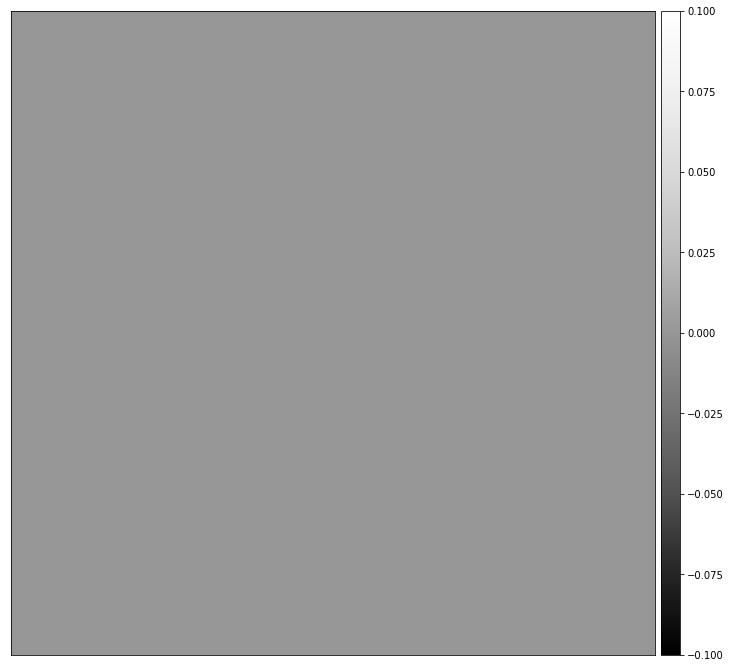

In [183]:
import numpy as np
import earthpy.plot as ep
import os
import rasterio
from rasterio.plot import show

#train_tiffs = os.listdir("./")

train_tiffs = ['image1_ndvi.tif'] 
train_tiffs.sort()
for tiff in train_tiffs:
    if tiff.count("tif")>0:
        print(tiff)
        fp = r''+tiff
        raster = rasterio.open(fp)

        bands = []

        # Read the raster's bands to an array
        for i in range(raster.count):
            bands.append(raster.read((i+1), out_dtype=raster.dtypes[i]))

        # Convert to an iterable np.ndarray and plot in a 3-column grid
        ep.plot_bands(np.array(bands), cols=3) 

A floating point type should be used (the default).

In [195]:
!otbcli_RadiometricIndices -in WorkshopData/internals/image1.tif \
    -out image1_ndvi1.tif \
    -channels.red 1 \
    -channels.green 2 \
    -channels.blue 3 -channels.nir 4 \
    -list Vegetation:NDVI

2022-06-22 17:33:10 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 17:33:10 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 17:33:10 (INFO): OTB will use at most 8 threads
2022-06-22 17:33:10 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 17:33:10 (INFO): Vegetation:NDVI added.
2022-06-22 17:33:10 (INFO): Estimated memory for full processing: 122.032MB (avail.: 128 MB), optimal image partitioning: 1 blocks
2022-06-22 17:33:10 (INFO): File image1_ndvi1.tif will be written in 1 blocks of 2000x2000 pixels
Writing image1_ndvi1.tif...: 100% [**************************************************]2022-06-22 17:33:11 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_ndvi1.tif)
 (0 seconds)


image1_ndvi1.tif


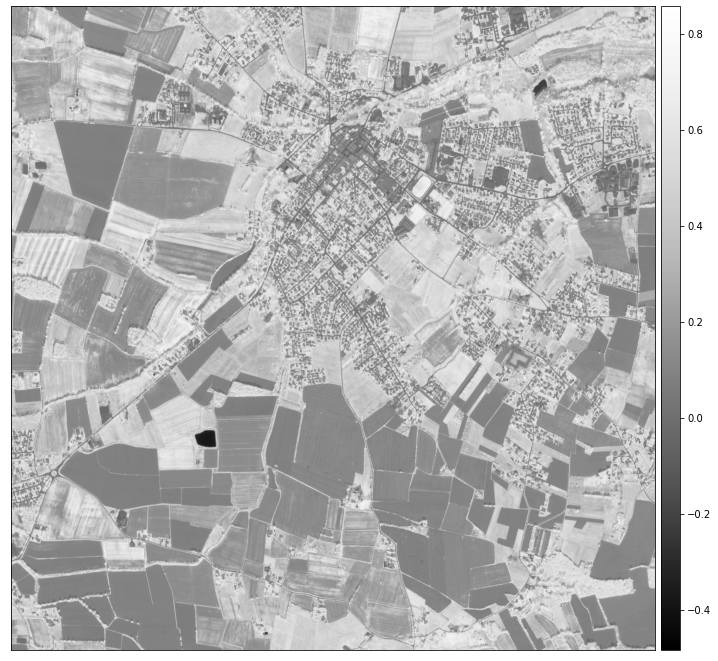

In [196]:
import numpy as np
import earthpy.plot as ep
import os
import rasterio
from rasterio.plot import show

#train_tiffs = os.listdir("./")

train_tiffs = ['image1_ndvi1.tif'] 
train_tiffs.sort()
for tiff in train_tiffs:
    if tiff.count("tif")>0:
        print(tiff)
        fp = r''+tiff
        raster = rasterio.open(fp)

        bands = []

        # Read the raster's bands to an array
        for i in range(raster.count):
            bands.append(raster.read((i+1), out_dtype=raster.dtypes[i]))

        # Convert to an iterable np.ndarray and plot in a 3-column grid
        ep.plot_bands(np.array(bands), cols=3) 

#### .geom files

Look into the image1.geom file with a text editor. What seems to be its purpose? Which
processing operations require this type of information?


[WorkshopData/internals/image1.geom](WorkshopData/internals/image1.geom)

The geom file contains information necessary for geometric and radiometric image corrections.

**Extended filenames** Extended filenames are used to influence the image reading and writing process in
Orfeo ToolBox. They are not application specific, but can be used with any Orfeo ToolBox based tool.
The full list of options is listed in the section Extended filename for reader and writer Software Guide.
We will illustrate here a few of them.

**Read options**

Compare the following command outputs:
````
$ otbcli_ReadImageInfo -in "image1.tif"
$ otbcli_ReadImageInfo -in "image1.tif?&skipgeom=true"
````


In [255]:
! otbcli_ReadImageInfo -in WorkshopData/internals/image1.tif  > log ;\
  otbcli_ReadImageInfo -in "WorkshopData/internals/image1.tif?&skipgeom=true" > log1 ;\
  diff -ru log log1

--- log	2022-06-22 23:11:04.966136762 +0000
+++ log1	2022-06-22 23:11:05.126137038 +0000
@@ -1,8 +1,7 @@
-2022-06-22 23:11:04 (INFO): Default RAM limit for OTB is 128 MB
-2022-06-22 23:11:04 (INFO): GDAL maximum cache size is 1600 MB
-2022-06-22 23:11:04 (INFO): OTB will use at most 8 threads
-2022-06-22 23:11:04 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
-2022-06-22 23:11:04 (INFO): 
+2022-06-22 23:11:05 (INFO): Default RAM limit for OTB is 128 MB
+2022-06-22 23:11:05 (INFO): GDAL maximum cache size is 1600 MB
+2022-06-22 23:11:05 (INFO): OTB will use at most 8 threads
+2022-06-22 23:11:05 (INFO): 
 Image general information:
 	Number of bands : 4
 	No data flags : Not found
@@ -10,23 +9,14 @@
 	Size :  [2000,2000]
 	Origin :  [5400.5,4300.5]
 	Spacing :  [1,1]
-	Estimated ground spacing (in meters): [2.13742,2.06336]
+	Estimated ground spacing (in meters): [5169.26,6813.77]
 
 Image acquisition information:
-	Sensor : PHR 1A
-	Image identi

Compare the following command outputs:
````
$ otbcli_ReadImageInfo -in "WorkshopData/internals/image2.tif"
$ otbcli_ReadImageInfo -in "WorkshopData/internals/image2.tif?&geom=image1.geom"
````

What is the effect of the geom parameter? What can be its purpose?

In [258]:
!otbcli_ReadImageInfo -in "WorkshopData/internals/image2.tif" > log ; \
    otbcli_ReadImageInfo -in "WorkshopData/internals/image2.tif?&geom=WorkshopData/internals/image1.geom" > log1 ; \
    diff -ru log log1

--- log	2022-06-22 23:17:24.466769915 +0000
+++ log1	2022-06-22 23:17:24.666770240 +0000
@@ -1,7 +1,7 @@
 2022-06-22 23:17:24 (INFO): Default RAM limit for OTB is 128 MB
 2022-06-22 23:17:24 (INFO): GDAL maximum cache size is 1600 MB
 2022-06-22 23:17:24 (INFO): OTB will use at most 8 threads
-2022-06-22 23:17:24 (INFO): No kwl metadata found in file WorkshopData/internals/image2.tif
+2022-06-22 23:17:24 (INFO): Loading kwl metadata from external geom file WorkshopData/internals/image1.geom
 2022-06-22 23:17:24 (INFO): 
 Image general information:
 	Number of bands : 4
@@ -10,14 +10,23 @@
 	Size :  [2000,2000]
 	Origin :  [6730.5,6300.5]
 	Spacing :  [1,1]
-	Estimated ground spacing (in meters): [7189.7,6813.77]
+	Estimated ground spacing (in meters): [2.14342,2.06613]
 
 Image acquisition information:
-	Sensor : 
-	Image identification number: 
+	Sensor : PHR 1A
+	Image identification number: 602631101-002
+	Acquisition time : 2012-11-15T11:05:00
+	Country : France
+	Town : Sainte-Foy

**Read option** The skipgeom read parameter allows to ignore the associated geom file. The ground pixel
size is false and the acquisition date and sensor information has disappeared.
The geom extended filename parameter allows to attach a geom file to an existing image. Among other
things, it is useful for radiometric and geometric processing. By default, Orfeo ToolBox (via OSSIM) looks
for a geom file with the same name as the image.
#### Orfeo ToolBox internals 
**Write options**

Write options Among available write options from extended filenames, the gdal:co option allows to
pass file creation options directly to GDAL. With this option, and with the Tif file format options available
in GDAL, re-encode `image1.tif` to signed 12 bits with LZW compression.
Compare file sizes and image contents with the CompareImages application.
Another useful extended filename option is box. Use the box option to write only to a 100x100 pixels
square in the center of the image.

In [187]:
!otbcli_Convert -in WorkshopData/internals/image1.tif \
    -out "image1_comp.tif?&gdal:co:NBITS=12&gdal:co:COMPRESS=LZW" uint16

2022-06-22 17:28:05 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 17:28:05 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 17:28:05 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 17:28:05 (INFO): OTB will use at most 8 threads
2022-06-22 17:28:05 (INFO): Estimated memory for full processing: 183.029MB (avail.: 128 MB), optimal image partitioning: 2 blocks
2022-06-22 17:28:05 (INFO): File image1_comp.tif will be written in 3 blocks of 2000x667 pixels
Writing image1_comp.tif?&gdal:co:NBITS=12&gdal:co:COMPRESS=LZW...: 32% [****************                                  ]2022-06-22 17:28:05 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_comp.tif)
Writing image1_comp.tif?&gdal:co:NBITS=12&gdal:co:COMPRESS=LZW...: 100% [**************************************************] (1 seconds)


The size of the image is:

In [206]:
!du -h image1_comp.tif WorkshopData/internals/image1.tif

80K	image1_comp.tif
62M	WorkshopData/internals/image1.tif


8 MB are saved compared to the unsigned 16 bits image. The **CompareImages** application shows that
the content stays the same.
The box parameter is used as such:

In [191]:
!otbcli_Convert -in WorkshopData/internals/image1.tif \
    -out "image1_comp.tif?&box=1000:1000:100:100" uint16

2022-06-22 17:29:29 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 17:29:29 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 17:29:29 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 17:29:29 (INFO): OTB will use at most 8 threads
2022-06-22 17:29:29 (INFO): Writing user defined region [1000, 1099]x[1000, 1100]
2022-06-22 17:29:29 (INFO): Estimated memory for full processing: 0.38147MB (avail.: 128 MB), optimal image partitioning: 1 blocks
2022-06-22 17:29:29 (INFO): File image1_comp.tif will be written in 1 blocks of 100x100 pixels
Writing image1_comp.tif?&box=1000:1000:100:100...: 100% [**************************************************]2022-06-22 17:29:29 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_comp.tif)
 (0 seconds)


After this command, the output image is an extract of the total output, beginning at the (1000,1000)
index and of size 100x100. This option can be used to visualize a result before processing the full image

WorkshopData/internals/image1.tif


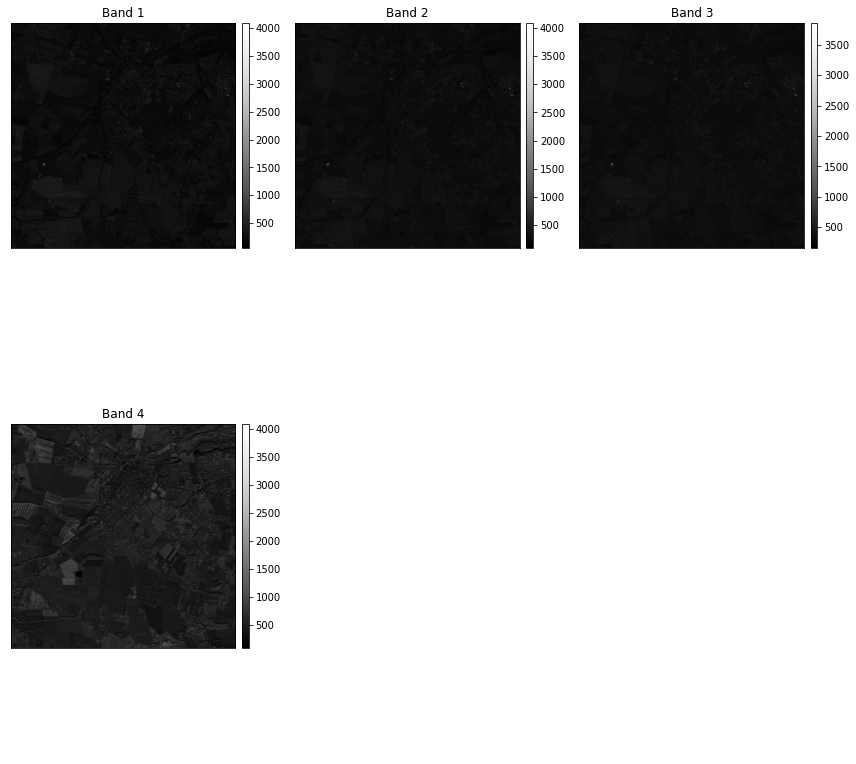

image1_comp.tif


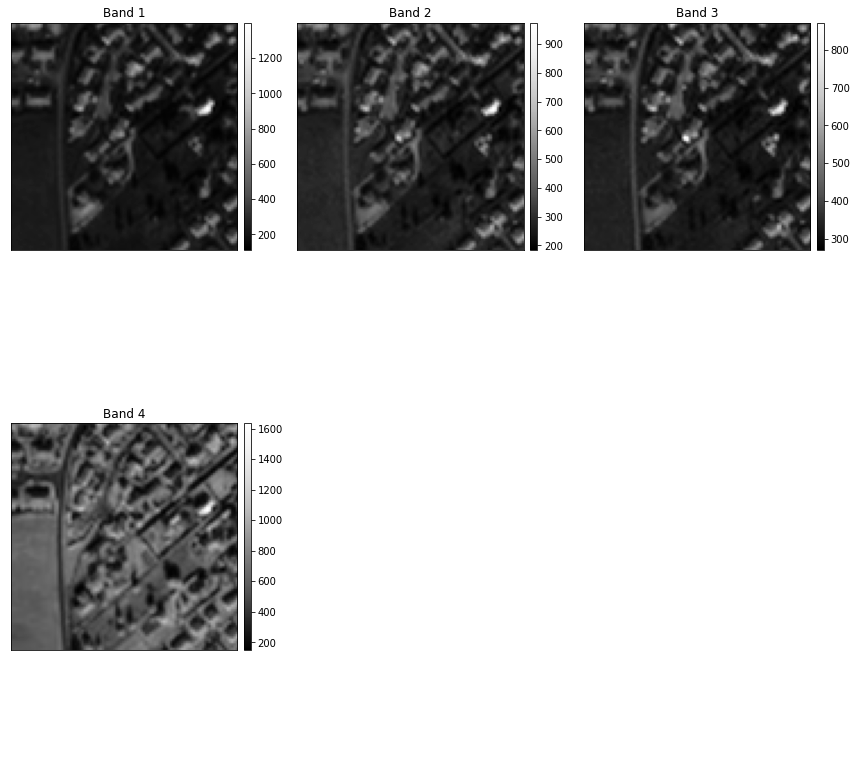

In [264]:
import numpy as np
import earthpy.plot as ep
import os
import rasterio
from rasterio.plot import show

#train_tiffs = os.listdir("./")

train_tiffs = ['WorkshopData/internals/image1.tif','image1_comp.tif'] 
train_tiffs.sort()
for tiff in train_tiffs:
    if tiff.count("tif")>0:
        print(tiff)
        fp = r''+tiff
        raster = rasterio.open(fp)

        bands = []

        # Read the raster's bands to an array
        for i in range(raster.count):
            bands.append(raster.read((i+1), out_dtype=raster.dtypes[i]))

        # Convert to an iterable np.ndarray and plot in a 3-column grid
        ep.plot_bands(np.array(bands), cols=3) 

### Streaming management 

By default, Orfeo ToolBox chooses the tiling method most suitable to the input
image, and the block size which maximizes memory usage. Memory usage is specified to the application,
or with the OTB_MAX_RAM_HINT environment variable. However, it is possible to modify this behavior
with writer extended filenames.
1. Use the LocalStatisticsExtraction application to process the first band of image1.tif with a
radius of 9.
2. Execute the above operation a second time, but this time completely disable streaming with the
streaming:type extended filename option. What do you notice?
3. Execute the above operation a third time, but this time ask for a split of 1000 strips. Use the streaming:type, streaming:sizemode and streaming:sizevalue. What do you notice?


To observe these effects, it is recommended to open a system monitor tool and look at CPU load and
I/O throughput.

In [218]:
!otbcli_LocalStatisticExtraction -in WorkshopData/internals/image1.tif -out image1_ls.tif \
    -radius 9

2022-06-22 18:02:15 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 18:02:15 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 18:02:15 (INFO): OTB will use at most 8 threads
2022-06-22 18:02:15 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 18:02:15 (INFO): Estimated memory for full processing: 289.185MB (avail.: 128 MB), optimal image partitioning: 3 blocks
2022-06-22 18:02:15 (INFO): File image1_ls.tif will be written in 4 blocks of 2000x501 pixels
Writing image1_ls.tif...: 24% [************                                      ]2022-06-22 18:02:15 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_ls.tif)
Writing image1_ls.tif...: 100% [**************************************************] (2 seconds)


We notice that the computation is done in several steps, interleaved with disk I/O. By default, Orfeo
ToolBox specifies the optimal tiling.
To completely disable streaming, use the following extended filename options:

In [219]:
!otbcli_LocalStatisticExtraction -in WorkshopData/internals/image1.tif * \
    -out "image1_ls.tif?&streaming:type=none" -radius 9

2022-06-22 18:02:24 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 18:02:24 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 18:02:24 (INFO): OTB will use at most 8 threads
2022-06-22 18:02:24 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 18:02:24 (WARNING): Streaming configuration through extended filename is used. Any previous streaming configuration (ram value, streaming mode ...) will be ignored.
2022-06-22 18:02:24 (WARNING): Streaming is explicitly disabled, sizemode and sizevalue will be ignored.
NumberOfDivisionsTiledStreamingManager (0x56323ed2a3d0): NumberOfDivisions set to 0 : streaming disabled

2022-06-22 18:02:24 (INFO): File image1_ls.tif will be written in 1 blocks of 2000x2000 pixels
Writing image1_ls.tif?&streaming:type=none...: 100% [**************************************************]2022-06-22 18:02:26 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_ls.ti

When processing is done in a single pass, only one disk write follows.

In [221]:
!otbcli_LocalStatisticExtraction -in WorkshopData/internals/image1.tif \
    -out "image1_ls.tif?&streaming:type=stripped&streaming:sizemode=nbsplits&streaming:sizevalue=1000" \
    -radius 9

2022-06-22 18:03:20 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 18:03:20 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 18:03:20 (INFO): OTB will use at most 8 threads
2022-06-22 18:03:20 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 18:03:20 (WARNING): Streaming configuration through extended filename is used. Any previous streaming configuration (ram value, streaming mode ...) will be ignored.
2022-06-22 18:03:20 (INFO): File image1_ls.tif will be written in 1000 blocks of 2000x2 pixels
Writing image1_ls.tif?&streaming:type=stripped&streaming:sizemode=nbsplits&streaming:sizevalue=1000...: 0% [                                                  ]2022-06-22 18:03:20 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_ls.tif)
Writing image1_ls.tif?&streaming:type=stripped&streaming:sizemode=nbsplits&streaming:sizevalue=1000...: 100% [*******************************************

This time, we see multiple computation and disk writing steps. Computation time can be almost twice
as long, because over tiling is suboptimal.

### Multi-threading 

By default, every filter in Orfeo ToolBox uses all available processing cores. This behavior can be altered with the ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS environment variable.

Follow the previous example with the LocalStatisticsExtraction application and disable streaming.

Use the above environment variable to decrease, and then increase the number of threads. What do you
notice?

You can use the time command to measure execution time.

Here’s how to set the number of threads to 1:

In [222]:
!export ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=1 ; otbcli_LocalStatisticExtraction -in WorkshopData/internals/image1.tif \
    -out "image1_ls.tif?&streaming:type=none" \
    -radius 9

2022-06-22 18:05:46 (INFO): Default RAM limit for OTB is 128 MB
2022-06-22 18:05:46 (INFO): GDAL maximum cache size is 1600 MB
2022-06-22 18:05:46 (INFO): OTB will use at most 1 threads
2022-06-22 18:05:46 (INFO): Loading kwl metadata from attached geom file WorkshopData/internals/image1.geom
2022-06-22 18:05:46 (WARNING): Streaming configuration through extended filename is used. Any previous streaming configuration (ram value, streaming mode ...) will be ignored.
2022-06-22 18:05:46 (WARNING): Streaming is explicitly disabled, sizemode and sizevalue will be ignored.
NumberOfDivisionsTiledStreamingManager (0x5601016d94f0): NumberOfDivisions set to 0 : streaming disabled

2022-06-22 18:05:46 (INFO): File image1_ls.tif will be written in 1 blocks of 2000x2000 pixels
Writing image1_ls.tif?&streaming:type=none...: 100% [**************************************************]2022-06-22 18:05:53 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (image1_ls.ti

In that case, computation time is much more significant. It can also be seen that increasing the number
too much does not improve performance above a certain point (typically the number of CPU cores).

## Image segmentation and export to GIS

### Description
Summary This exercise allows to get familiar with large scale segmentation using the MeanShift algorithm. It goes through each step of the procedure and shows how to export and use output segments in a
GIS.
* **Pre-requisites**

  * Installed software (Monteverdi and QGIS)
  * Output data from the VHR image pre-processing exercise
  * Know how OTB applications work (see corresponding exercise)

* **Goals** 
  * Know the steps required to perform a segmentation
  * Know how to optimize segmentation parameters
  * Know how to export results to a GIS
  
### Steps

* Data needed for this exercise can be found in the Data/segmentation folder.
* Image smoothing with the MeanShift algorithm The MeanShift algorithm performs a smoothing of
the image by preserving edges. It produces more homogeneous images and also keeps sharp boundaries
between regions. It aims at facilitating the segmentation step done by simple methods like connected
component computation. The algorithm performs iterative mean over pixels using a given neighborhood
(spatial and spectral).

Compute the smoothing of the image phr_orthopxs_osr_mipy_xt.tif using the application
MeanShiftSmoothing. Change the values of the ranger and spatialr parameters to see their influence.

Notes:
* the modesearch option allows to speedup computation but it is less stable. We will disable it in this
exercise.
* Spatial (spatialr) and spectral (ranger) radiuses are the most important parameters of the algorithm.
The first one corresponds to a number of pixels and the other one corresponds to a distance between
pixels in the spectral domain.
 foutpos output the spectral mean result for each pixel and will be used in the next questions.
* You can use the extended filename parameter box to find the optimal parameters ranger and spatialr
without processing all the input image.

In the next step of the exercise we will use ranger around 25 and spatialr around 3 (to limit computation time). 

Segmentation This step allows to produce the initial segmentation using the output images from the
smoothing step (fout and foutpos). Adjacent pixels in the fout image for which the spectral distance is
lower than ranger and for which the estimated position in foutpos is lower than spatialr will be grouped in
the same connected component (segment).

This step is performed on a tile basis. The application allows to set the tile size with parameters tilesizex
and tilesizey.

Finally, minsize allows to remove small regions (the threshold corresponds to a number of pixels).

Use the LSMSSegmentation application to perform this step. Some tips regarding the application
configuration:

* Use minsize equal to 0 in this first step
* The output image is a labelled image in which each pixel corresponds to an integer value (unique for
each segment). It is advisable to encode the output image in uint32 to have enough unique labels.
Indeed the segmentation can generate a large number of segments.
* Parameters ranger and spatialr should have smaller values than in the smoothing step. You can start
by dividing the value by two.
Use the optimal mode from the ColorMapping application to generate a nice output from the labelled
image.

**Handle small regions**

After the initial segmentation, there is generally lots of small regions which do
not correspond to any object or region of interest. The LSMSSegmentation application allows to filter
those regions (minsize parameter), but it is also possible to add a post-processing to fuse iterative adjacent
regions (using a spectral criteria). This post-processing can be done with LSMSSmallRegionsMerging.
Use this application to re-process the initial segmentation by fusing all regions smaller than 50 pixels.
Use the optimal mode from the ColorMapping application to generate a nice output from the labelled
image.

**Vectorization**

The last step allows to export polygons to a vector file. The LSMSVectorization application performs the vectorization and computes the mean and the variance on each segment using a support
image.

* Start by computing the NDVI from input image.
* Then, use the ConcatenateImages application to stack the input radiometry with the NDVI (be careful with the encoding of the output image).
* Use the **LSMSVectorization** using this image and the segmentation results. You can choose for instance ESRI Shapefile (.shp extension) or sqlite (.sqlite extension) as the vector data format (all formats supported by GDAL/OGR can be used here).
* Open the input image and the vector layer in QGIS. Adapt the vector rendering to display polygon edges in red and the interior ring with 100% transparency. Analyze the segmentation and comment the result.
* Open and comment the attribute table.

**Filter segments in QGIS**

Use the selection tool in QGIS using SQL expressions and the layer attributes
table to select polygons which do not correspond to shadow areas and copy them in another layer.
Use the calculator on attributes to create a new column which will store polygon’s compacity:

$$compactness =
{\sqrt{area} \over {perimeter}}
$$
Use the attribute selector interface to select compact polygons with a high NDVI value (trees?). Copy
the result to a new layer in QGIS

### Image smoothing using the MeanShift algorithm

In [304]:
!otbcli_MeanShiftSmoothing -in WorkshopData/segmentation/phr_orthopxs_osr_mipy_xt.tif \
    -fout meanshift.tif \
    -foutpos meanshift_pos.tif \
    -ranger 25 \
    -spatialr 3 \
    -maxiter 10 -modesearch 0

2022-06-23 10:42:55 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:42:55 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:42:55 (INFO): OTB will use at most 8 threads
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2022-06-23 10:42:55 (INFO): No kwl metadata found in file WorkshopData/segmentation/phr_orthopxs_osr_mipy_xt.tif
2022-06-23 10:42:55 (INFO

* *spatialr* corresponds to the spatial radius. A higher value will lead to a stronger smoothing and will
also take more time.
* *ranger* is the spectral radius which means how pixels in the spatial radius and with close radiometry
* *values* will be averaged. A higher ranger will increase the smoothing effect.
foutpos can not be interpreted. It will be used in the next step of the exercise.

### The segmentation step can be performed with the following command:



In [306]:
!otbcli_LSMSSegmentation -in meanshift.tif \
    -inpos meanshift_pos.tif \
    -out init_seg.tif uint32 \
    -ranger 10 \
    -spatialr 2

2022-06-23 10:44:39 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:44:39 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:44:39 (INFO): OTB will use at most 8 threads
2022-06-23 10:44:39 (INFO): No kwl metadata found in file meanshift_pos.tif
2022-06-23 10:44:39 (INFO): No kwl metadata found in file meanshift.tif
2022-06-23 10:44:39 (INFO): Number of tiles: 8 x 8
2022-06-23 10:44:39 (INFO): Tile shifting ...
2022-06-23 10:44:39 (INFO): File init_seg_0_0_SEG.tif will be written in 1 blocks of 501x501 pixels
2022-06-23 10:44:40 (INFO): File init_seg_0_1_SEG.tif will be written in 1 blocks of 501x501 pixels
2022-06-23 10:44:40 (INFO): File init_seg_0_2_SEG.tif will be written in 1 blocks of 501x501 pixels
2022-06-23 10:44:40 (INFO): File init_seg_0_3_SEG.tif will be written in 1 blocks of 501x501 pixels
2022-06-23 10:44:41 (INFO): File init_seg_0_4_SEG.tif will be written in 1 blocks of 501x501 pixels
2022-06-23 10:44:41 (INFO): File init_seg_0_5_SEG.tif will be written

It is pretty hard to interpret directly the output image. It can be colorized using the following command:

In [307]:
!otbcli_ColorMapping -in init_seg.tif \
    -method optimal \
    -out init_seg_cm.tif uint8 

2022-06-23 10:45:31 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:45:31 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:45:31 (INFO): OTB will use at most 8 threads
2022-06-23 10:45:31 (INFO): Color mapping with an optimized look-up table
2022-06-23 10:45:31 (INFO): No kwl metadata found in file init_seg.tif
2022-06-23 10:45:31 (INFO): Estimated memory for full processing: 122.07MB (avail.: 128 MB), optimal image partitioning: 1 blocks
2022-06-23 10:45:31 (INFO): File init_seg_cm.tif will be written in 1 blocks of 4000x4000 pixels
Writing init_seg_cm.tif...: 100% [**************************************************] (0 seconds)


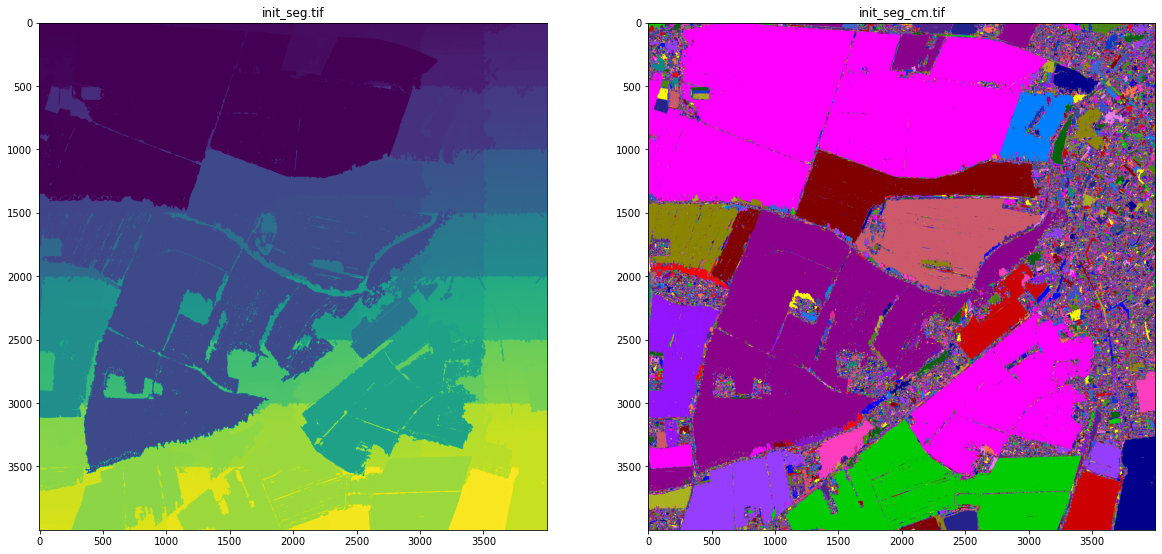

In [308]:
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(20, 10))
columns = 2
rows = 1
tiffs=["init_seg.tif","init_seg_cm.tif"]
for i in range(1, columns*rows +1):
    img = cv2.imread("./"+tiffs[i-1], cv2.IMREAD_UNCHANGED)
    subPlot=fig.add_subplot(rows, columns, i)
    subPlot.set_title(tiffs[i-1])
    plt.imshow(img)
plt.show()

This application performs color mapping and the algorithm analyzes nearest segments to maximize the
contrast between polygons.

The segmented image can then be analyzed. We can see a lot of small regions which do not correspond
to real objects. There are 2 ways to filter those regions by using the minsize parameter of the **LSMSSegmentation** application or by fusing them (next step)

### Dealing with small regions

Small regions can be merged with the command

In [312]:
!otbcli_LSMSSmallRegionsMerging -in meanshift.tif \
    -inseg init_seg.tif \
    -out final_seg.tif uint32 \
    -minsize 100

2022-06-23 10:49:03 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:49:03 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:49:03 (INFO): OTB will use at most 8 threads
2022-06-23 10:49:03 (INFO): No kwl metadata found in file meanshift.tif
2022-06-23 10:49:03 (INFO): No kwl metadata found in file init_seg.tif
2022-06-23 10:49:03 (INFO): Estimated memory for full processing: 183.067MB (avail.: 128 MB), optimal image partitioning: 2 blocks
2022-06-23 10:49:03 (INFO): Estimation will be performed in 3 blocks of 4000x1334 pixels
Retrieve region count...: 100% [**************************************************] (0 seconds)
2022-06-23 10:49:03 (INFO): Number of tiles: 8 x 8
2022-06-23 10:49:03 (INFO): Sums calculation ...
2022-06-23 10:49:04 (INFO): Building LUT for small regions merging ...
2022-06-23 10:50:54 (INFO): Elapsed time: 160.651 seconds
2022-06-23 10:50:54 (INFO): Estimated memory for full processing: 244.102MB (avail.: 128 MB), optimal image partitioning: 2 bl

Then, we use again the **ColorMapping** application to colorize the output.

In [313]:
!otbcli_ColorMapping -in final_seg.tif \
    -method optimal \
    -out final_seg_cm.tif uint8

2022-06-23 10:52:58 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:52:58 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:52:58 (INFO): OTB will use at most 8 threads
2022-06-23 10:52:58 (INFO): Color mapping with an optimized look-up table
2022-06-23 10:52:58 (INFO): No kwl metadata found in file final_seg.tif
2022-06-23 10:52:58 (INFO): Estimated memory for full processing: 122.07MB (avail.: 128 MB), optimal image partitioning: 1 blocks
2022-06-23 10:52:58 (INFO): File final_seg_cm.tif will be written in 1 blocks of 4000x4000 pixels
Writing final_seg_cm.tif...: 100% [**************************************************] (0 seconds)


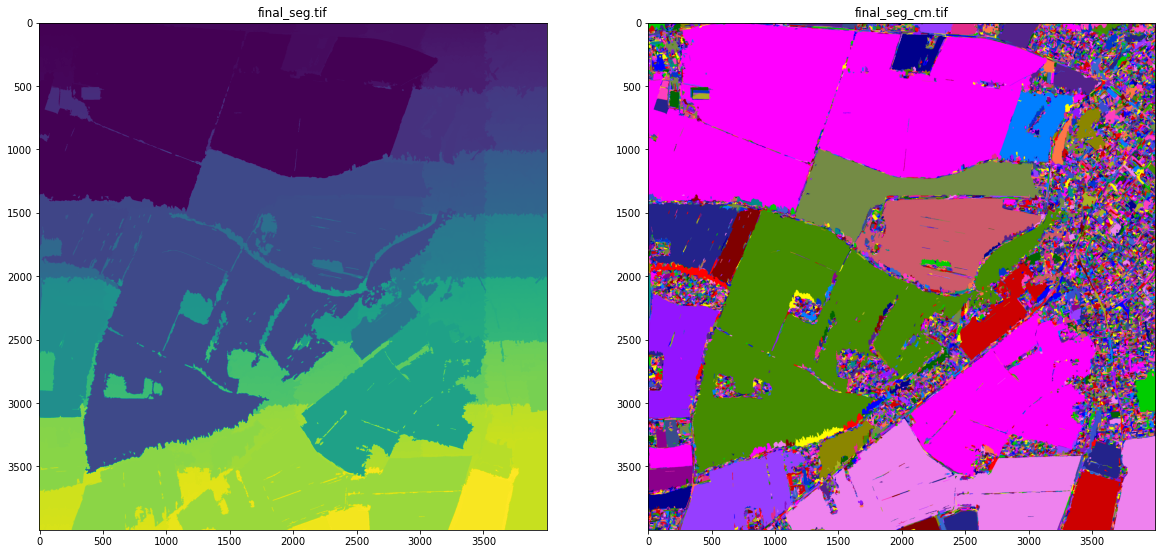

In [316]:
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(20, 10))
columns = 2
rows = 1
tiffs=["final_seg.tif","final_seg_cm.tif"]
for i in range(1, columns*rows +1):
    img = cv2.imread("./"+tiffs[i-1], cv2.IMREAD_UNCHANGED)
    subPlot=fig.add_subplot(rows, columns, i)
    subPlot.set_title(tiffs[i-1])
    plt.imshow(img)
plt.show()

By comparing both colorized segmentations we can see that regions smaller than minsize where fused
with adjacent regions close in terms of radiometry.

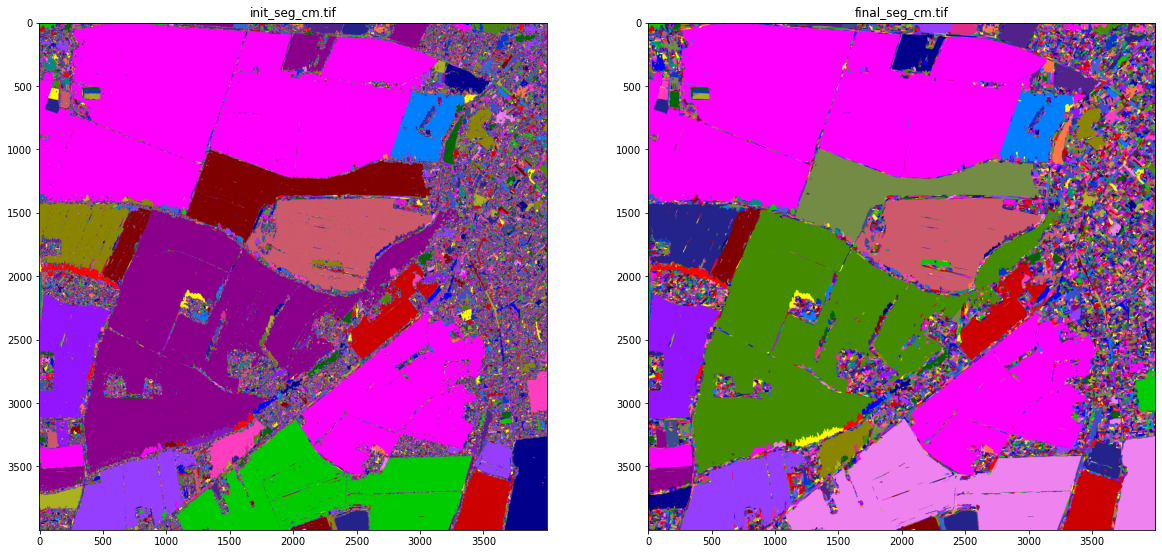

In [317]:
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(20, 10))
columns = 2
rows = 1
tiffs=["init_seg_cm.tif","final_seg_cm.tif"]
for i in range(1, columns*rows +1):
    img = cv2.imread("./"+tiffs[i-1], cv2.IMREAD_UNCHANGED)
    subPlot=fig.add_subplot(rows, columns, i)
    subPlot.set_title(tiffs[i-1])
    plt.imshow(img)
plt.show()

### Vectorization

Start by computing the NDVI index from the initial image:

In [320]:
!otbcli_RadiometricIndices -in WorkshopData/segmentation/phr_orthopxs_osr_mipy_xt.tif \
    -out phr_ndvi.tif \
    -list Vegetation:NDVI \
    -channels.blue 3 \
    -channels.red 1 \
    -channels.green 2 \
    -channels.nir 4

2022-06-23 10:56:15 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:56:15 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:56:15 (INFO): OTB will use at most 8 threads
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2022-06-23 10:56:15 (INFO): No kwl metadata found in file WorkshopData/segmentation/phr_orthopxs_osr_mipy_xt.tif
2022-06-23 10:56:15 (INFO

Then, concatenate input image and NDVI index

In [321]:
!otbcli_ConcatenateImages -il WorkshopData/segmentation/phr_orthopxs_osr_mipy_xt.tif phr_ndvi.tif\
    -out phr_radio_ndvi.tif

2022-06-23 10:57:01 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:57:01 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:57:01 (INFO): OTB will use at most 8 threads
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2022-06-23 10:57:01 (INFO): No kwl metadata found in file WorkshopData/segmentation/phr_orthopxs_osr_mipy_xt.tif
2022-06-23 10:57:01 (INFO

Finally, we can perform the vectorization

In [326]:
!otbcli_LSMSVectorization -in phr_radio_ndvi.tif \
    -inseg final_seg.tif -out segmentation.shp

2022-06-23 10:58:34 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 10:58:34 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 10:58:34 (INFO): OTB will use at most 8 threads
2022-06-23 10:58:34 (INFO): No kwl metadata found in file final_seg.tif
2022-06-23 10:58:34 (INFO): Number of tiles: 8 x 8
2022-06-23 10:58:34 (INFO): Estimated memory for full processing: 183.067MB (avail.: 128 MB), optimal image partitioning: 2 blocks
2022-06-23 10:58:34 (INFO): Estimation will be performed in 3 blocks of 4000x1334 pixels
Retrieve region count...: 100% [**************************************************] (0 seconds)
2022-06-23 10:58:35 (INFO): No kwl metadata found in file phr_radio_ndvi.tif
2022-06-23 10:58:35 (INFO): Vectorization ...
2022-06-23 10:58:38 (INFO): Merging polygons across tiles ...
2022-06-23 10:58:56 (INFO): Elapsed time: 26.6164 seconds


Bellow, we can see that for each polygon we’ve access to the mean and variance in each spectral band (including NDVI).

In [328]:
# TODO: folium map showing the polygons with attributes

### Polygons filtering

To select all segments not belonging to shadow areas we are using the expression features as follows:

```meanB0 > 140 or meanB1 > 140 or meanB2 > 140 or meanB3 > 140```

We can use the following command to proceed.


In [1]:
!ogr2ogr segmentation_no_shadow.shp segmentation.shp segmentation -sql 'SELECT * FROM segmentation WHERE  "meanB0" > 140 or "meanB1" > 140 or "meanB2" > 140 or "meanB3" > 140'

Warning 1: layer names ignored in combination with -sql.


Then, we use the field calculator to create a new virtual field (real type) called compac with the following formula:

```sqrt(area(geometry) / perimeter(geometry))```




In [5]:
!rm -f segmentation_compac.* ; \
    ogr2ogr -dialect SQLite \
        -sql "select *, sqrt(ST_Area(geometry) / ST_Length(ST_Boundary(geometry))) as compac from segmentation_no_shadow" \
        segmentation_compac.shp segmentation_no_shadow.shp

Finally, to select small and compact objects with high NDVI we can use the following expression:

```compac > 0.1 and nbPixels < 500 and meanB4 > 0.2```


In [6]:
!rm -f small_and_compac_ojects.* ; \
    ogr2ogr -sql 'SELECT * FROM segmentation_compac WHERE "compac" > 0.1 and "nbPixels" < 500 and "meanB4" > 0.2' \
    small_and_compac_ojects.shp segmentation_compac.shp

In [7]:
# TODO: folium map showing the polygons with attributes